In [29]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add

In [30]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

Train: X=(60000, 28, 28, 1), y=(60000,)
Test: X=(10000, 28, 28, 1), y=(10000,)
8


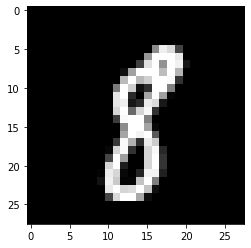

In [31]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
pyplot.imshow(trainX[300,:,:,0], cmap='gray')
print(trainY[300])

In [32]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
print(trainY[300])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [33]:
# convert from integers to floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# normalize to range 0-1
trainX = trainX / 255.0
testX = testX / 255.0

In [34]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [35]:
model = ResNet18(10)
model.build(input_shape = (None,28,28,1))
#use categorical_crossentropy since the label is one-hot encoded
opt = SGD(learning_rate=0.001,momentum=0.9, decay=1e-4) #parameters suggested by He [1]
model.compile(optimizer = opt,loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          multiple                  3200      
                                                                 
 batch_normalization_24 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_9 (ResnetBlock  multiple       

In [36]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=3):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        print(trainX.shape)
        history = model.fit(trainX, trainY, epochs=3, batch_size=32, validation_data=(testX, testY), verbose=1)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [ ]:
scores, histories = evaluate_model(trainX, trainY)

(40000, 28, 28, 1)
Epoch 1/3
1250/1250 [==============================] - 686s 547ms/step - loss: 0.2280 - accuracy: 0.9290 - val_loss: 0.1037 - val_accuracy: 0.9677
Epoch 2/3
1250/1250 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9802

In [13]:
from sklearn.metrics import confusion_matrix,classification_report, precision_recall_fscore_support,ConfusionMatrixDisplay
(trainX, trainY), (testX, testY) = mnist.load_data()

Y_pred = model.predict(testX)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testY, y_pred)